# Lab 6: Differential equations
**Theo Puranen Åhfeldt**

# **Abstract**

The objective of this report is to implement time stepping methods for approximating solutions to differential equations. The methods that are implemented are the theta method for scalar and vector initial value problems, as well as the Euler-Maruyama method for approximating a path of a stochastic process. The implementations are tested by comparing the resulting approximation with the exact solution of a model problem. The tests indicates that the implementations are succesful.

# **Set up environment**

To have access to the neccessary modules you have to run this cell.

In [1]:
# Load neccessary modules.
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# **Introduction**

The time stepping methods in this report are base on ordinary differential equations which for a function $u(t)$ with derivative $\dot{u}(t)$ and domain $[0, T]$ take the form:

$$\begin{aligned}
\dot{u}(t) &= f(u(t), t), \quad 0 < t \leq T\\
u(0) &= u_0
\end{aligned}$$

In the scalar case, the codomain of $u$ is $R$ and $f: R \times [0,T] \to R$. In vector case (also known as a system of initial value problems) the codomain is $R^n$ and $f: R^N \times [0,T] \to R^N$

# **Method**

The theta method is described by a single time stepping equation. Rewriting this equation on the form $g(x, y) = 0$ allows us to calculate the next time step as the root of $g(x, y)$ using Newton's method. This is done almost exactly the same in both the case of the scalar and the vector initial value problem. For simulating paths of a stochastic process, the time stepping rule is explicit and only requires some simple calculations in addition to drawing a sample from a normal distribution using `numpy.random.normal`. The accuracy of the theta method is tested using differential equations with known solutions to compare against.

## Time stepping for scalar initial value problem du/dt = f(u,t)

I have chosen to implement the theta method to solve the initial value problem. The implicit step rule for the theta method looks like this:

$$U(t_n) = U(t_{n-1}) + k_n(\theta f(U(t_{n-1}), t_{n-1}) + (1 - \theta)f(U(t_{n}), t_{n}))$$

Where $\theta \in [0, 1]$ and $k_n = t_n - t_{n-1}$. $\theta = 1$ corresponds to the explicit Euler's method, $\theta = 0$ corresponds to the implicit Euler's method and $\theta = 1/2$ corresponds to the trapezoidal method. 

To calculate the next time step we rewrite the step equation as:

$$U(t_n) - U(t_{n-1}) - k_n(\theta f(U(t_{n-1}), t_{n-1}) + (1 - \theta)f(U(t_{n}), t_{n})) = 0$$

Which we can solve for $U(t_n)$ using Newton's method.

In [2]:
def theta_method(T, f, u0, n, theta):
    t = np.linspace(0, T, n)
    k = T/(n-1)
    u = np.zeros(n)
    u[0] = u0
    for i in range(1, n):
        fun = lambda u_i: u_i - u[i-1] - k*(theta*f(u[i-1], t[i-1]) + (1-theta)*f(u_i, t[i]))
        u[i] = optimize.newton(fun, u[i-1])
    return u

### Tests

To verify the accuracy of the theta method we use the model problem:

$$\dot{u}(t) = u(t),\quad u(0) = 1$$

And compare the approximation to the exact solution $e^t$.

In [3]:
def test_accuracy_theta_method(T, n, theta):
    t = np.linspace(0, T, n)
    f = lambda u, t: u
    result = theta_method(T, f, 1, n, theta)
    plt.title('Accuracy of theta method with theta = ' + str(theta))
    plt.plot(t, np.exp(t), label='exact solution')
    plt.plot(t, result, label='approximation', ls='--')
    plt.legend()
    plt.show()

To test stability we consider the following model problem:

$$\dot{u}(t) = -10u(t),\quad u(0) = u_0$$

This has one equilibrium point $u^* = 0$ which is stable. To test stability we use a small perturbations of $u^*$ (0.1) and see if the approximation approaches 0. Using $T=5$ and $k = T/n = 0.25$ we expect the explicit Euler's method to be unstable since $|1 + k\lambda| = |1 - 2.5| > 1$, while the trapezoidal method and the implicit Euler's method should be unconditionally stable for this model problem.

In [4]:
def test_stability_theta_method(theta):
    T = 5
    n = 20
    t = np.linspace(0, T, n)
    f = lambda u, t: -10*u
    result = theta_method(T, f, 0.1, n, theta)
    plt.title('Stability of theta method with theta = ' + str(theta))
    plt.plot(t, result)
    plt.show()

## Time stepping for a system of  initial value problems du/dt = f(u,t)

For a system of initial value problems we need Newton's method for vectors. I could not find any such method in numpy nor scipy so I will use my own implementation from lab 3.

In [5]:
def jacobian(f, x, h):
    return np.array([(f(x + dx) - f(x))/h for dx in h * np.identity(x.size)]).transpose()

def newtons_method_vector(f, x0):
    x = x0
    while np.linalg.norm(f(x)) > 1e-10:
        df = jacobian(f, x, 1e-8)
        dx = np.linalg.solve(df, -f(x))
        x = x + dx
    return x

Now the theta method for vectors is almost exactly the same, just adjusted to use vectors instead of scalars.

In [6]:
def theta_method_vector(T, f, u0, n, theta):
    t = np.linspace(0, T, n)
    k = T/(n-1)
    u = np.zeros((n, len(u0)))
    u[0] = u0
    for i in range(1, n):
        fun = lambda u_i: u_i - u[i-1] - k*(theta*f(u[i-1], t[i-1]) + (1-theta)*f(u_i, t[i]))
        u[i] = newtons_method_vector(fun, u[i-1])
    return u

### Tests

To verify the accuracy we use example 14.1 from the lecture notes. The system is:

$$
\begin{bmatrix}
\dot{\varphi}_1\\
\dot{\varphi}_2\\
\end{bmatrix} =
\begin{bmatrix}
-\nu & \gamma\\
0 & -\nu\\
\end{bmatrix}
\begin{bmatrix}
\varphi_1\\
\varphi_2\\
\end{bmatrix}
$$

With inital value $\varphi_1(0) = 0$ and $\varphi_2(0) = \kappa$. The solution to this system is:

$$
\begin{aligned}
\varphi_1(t) &= \gamma\kappa t e^{-\nu t}\\
\varphi_2(t) &= \kappa e^{-\nu t}\\
\end{aligned}
$$

We then simply plot the approximation against this exact solution.

In [7]:
def test_accuracy_theta_method_vector(T, n, theta):
    nu = 1
    gamma = 2
    kappa = 5
    f = lambda u, t: np.array([[-nu, gamma],[0, -nu]]) @ u
    t = np.linspace(0, T, n)
    result = np.transpose(theta_method_vector(T, f, [0, kappa], n, theta))

    phi1 = lambda t: gamma*kappa*t*np.exp(-nu*t)
    phi2 = lambda t: kappa*np.exp(-nu*t)

    plt.title('Accuracy of theta method with theta = ' + str(theta))
    plt.plot(t, phi1(t), label='exact solution 1')
    plt.plot(t, result[0], label='approximation 1', ls='--')
    plt.plot(t, phi2(t), label='exact solution 2')
    plt.plot(t, result[1], label='approximation 2', ls='--')
    plt.legend()
    plt.show()

To test the stability we use the model problem described by $f(u(t),t) = -Au(t)$. If $A$ is diagonalizable and only has positive eigen-values we know that the problem is stable, with equilibrium point $u^* = \hat{0}$. We construct such a matrix $A$ by calculating $XDX^{-1}$, where $X$ is a non-singular matrix and $D$ a diagonal matrix with only positive entries. We can then test the stability just like in the scalar case by using a peturbation of $u^*$ ($(0.1, -0,1)^T$) as initial value and seeing if the approximation approaches 0.

In [8]:
def test_stability_theta_method_vector(theta):
    X = np.array([[-2, 1],[5, 3]])
    A = X @ np.diag([3, 4]) @ np.linalg.inv(X)
    T = 10
    n = 20
    t = np.linspace(0, T, n)
    f = lambda u, t: -A @ u
    result = theta_method_vector(T, f, np.array([0.1, -0.1]), n, theta)
    plt.title('Stability of theta method with theta = ' + str(theta))
    plt.plot(t, result)
    plt.show()

## Simulate a trajectory of a stochastic differential equation

To simulate stochastic differential equations we use the formula:

$$x_n = x_{n-1} + \mu(x_{n-1}, t_{n-1})\Delta t_n + \sigma(x_{n-1}, t_{n-1}) \Delta W_n$$

In this case $\mu(x_{n-1}, t_{n-1}) = \mu x_{n-1}$ and $\sigma(x_{n-1}, t_{n-1}) = \sigma x_{n-1}$ which allows us to factor out $x_{n-1}$ to obtain:

$$x_n = x_{n-1}(1 + \mu\Delta t_n + \sigma\Delta W_n)$$

Where $\Delta W_n = Z\sqrt{\Delta t_n},\quad Z \sim N(0,1)$. To draw the samples of $Z$ we use `numpy.random.normal`, the rest of the implementation is a straight forward translation of the step formula.

In [9]:
def euler_maruyama_method(T, mu, sigma, x0, n):
    t = np.linspace(0, T, n)
    dt = T/(n-1)
    x = np.zeros(n)
    x[0] = x0
    dW = np.random.normal(size = (n,))*np.sqrt(dt)
    for i in range(1, n):
        x[i] = x[i-1]*(1 + mu*dt + sigma*dW[i])
    return x

### Tests

To test the implementation we simulate many trajectories and plot the average trajectory against the expected trajectory $x_0 e^{\mu t}$.

In [10]:
def test_euler_maruyama_method(T, mu, sigma, x0, n, num_runs):
    t = np.linspace(0, T, n)
    runs = np.zeros((num_runs, len(t)))
    for i in range(num_runs):
        runs[i] = euler_maruyama_method(T, mu, sigma, x0, n)
        plt.plot(runs[i])
    plt.title('Simulation of ' + str(num_runs) + ' stochastic trajectories')
    plt.show()
    avg_run = np.sum(runs, 0)/num_runs
    plt.plot(t, x0*np.exp(mu * t), label='expected')
    plt.plot(t, avg_run, label='average')
    plt.legend()
    plt.show()

# **Results**

This section shows the results of the tests as defined in the previous section.

## Accuracy of theta method (scalar)

The following code cells shows the accuracy for $\theta = 0$ (implicit Euler's method), $\theta = 1/2$ (trapezoidal method) and $\theta = 1$ (explicit Euler's method).

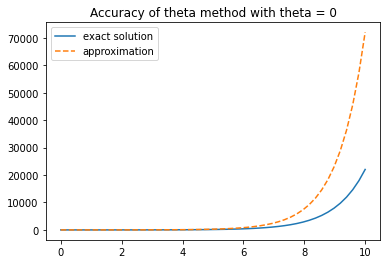

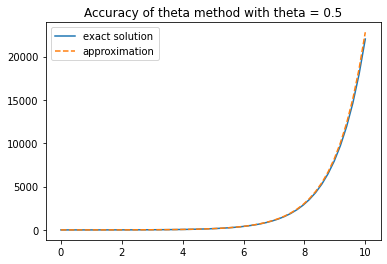

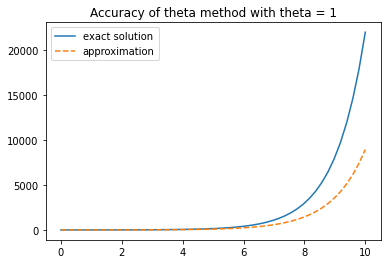

In [11]:
test_accuracy_theta_method(10, 50, 0)
test_accuracy_theta_method(10, 50, 0.5)
test_accuracy_theta_method(10, 50, 1)

## Stability of theta method (scalar)

The following code cells shows the stability for $\theta = 0$ (implicit Euler's method), $\theta = 1/2$ (trapezoidal method) and $\theta = 1$ (explicit Euler's method).

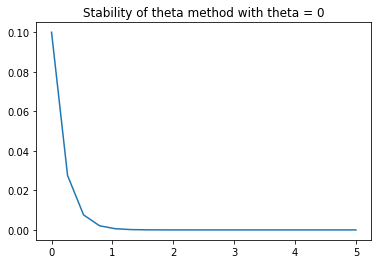

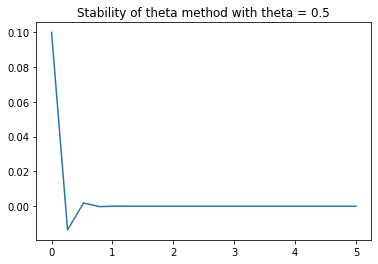

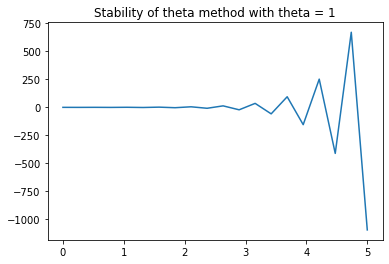

In [12]:
test_stability_theta_method(0)
test_stability_theta_method(0.5)
test_stability_theta_method(1)

## Accuracy of theta method (vector)

The following code cells shows the accuracy for $\theta = 0$ (implicit Euler's method), $\theta = 1/2$ (trapezoidal method) and $\theta = 1$ (explicit Euler's method).

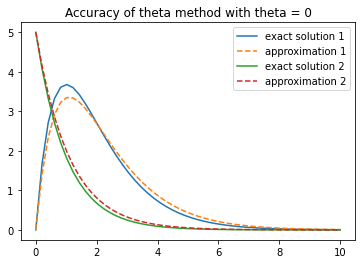

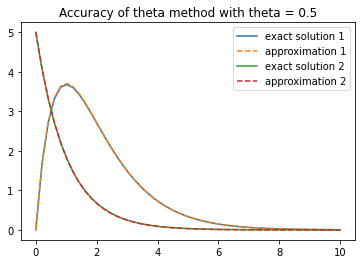

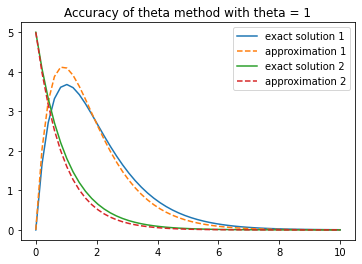

In [13]:
test_accuracy_theta_method_vector(10, 50, 0)
test_accuracy_theta_method_vector(10, 50, 0.5)
test_accuracy_theta_method_vector(10, 50, 1)

## Stability of theta method (vector)

The following code cells shows the stability for $\theta = 0$ (implicit Euler's method), $\theta = 1/2$ (trapezoidal method) and $\theta = 1$ (explicit Euler's method).

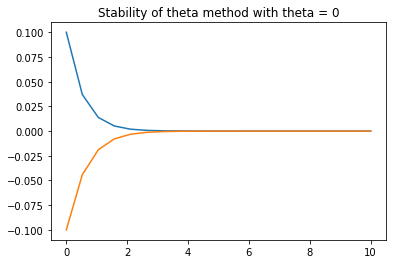

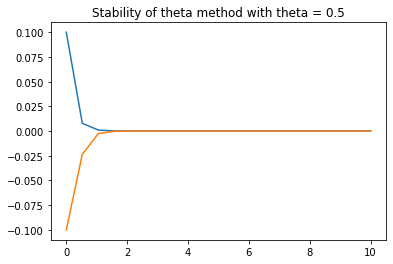

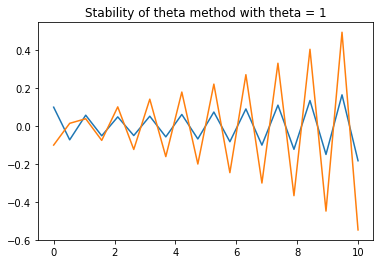

In [14]:
test_stability_theta_method_vector(0)
test_stability_theta_method_vector(0.5)
test_stability_theta_method_vector(1)

## Simulated trajectories of a stochastic differential equation

The following code cell plots all simulated trajectories as well as a comparison of the average trajectory against the expected trajectory.

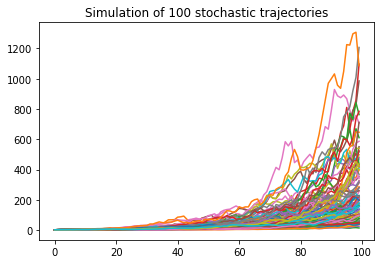

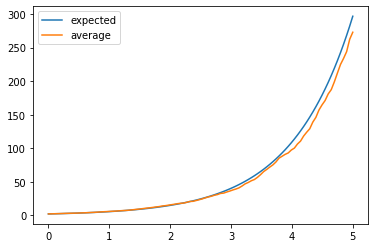

In [15]:
test_euler_maruyama_method(5, 1, 0.5, 2, 100, 100)

# **Discussion**

The theta method displays good accuracy, especially for the trapezoidal method. Euler's explicit method clearly does not approach 0, showing that it is indeed unstable for the model problems used in this report. The tests similarly shows that Euler's implicit method and the trapezoidal method do approach 0 and are stable as expected. As for the simulated trajectories of the stochastic differential equation, the average is very close to the expected outcome.